In [37]:
!pip install --upgrade pip -q

In [36]:
pip install cupy-cuda12x -q

Generated 81 discrete configurations
Conceptual core computed: True
Computing membership values via GPU Monte Carlo...


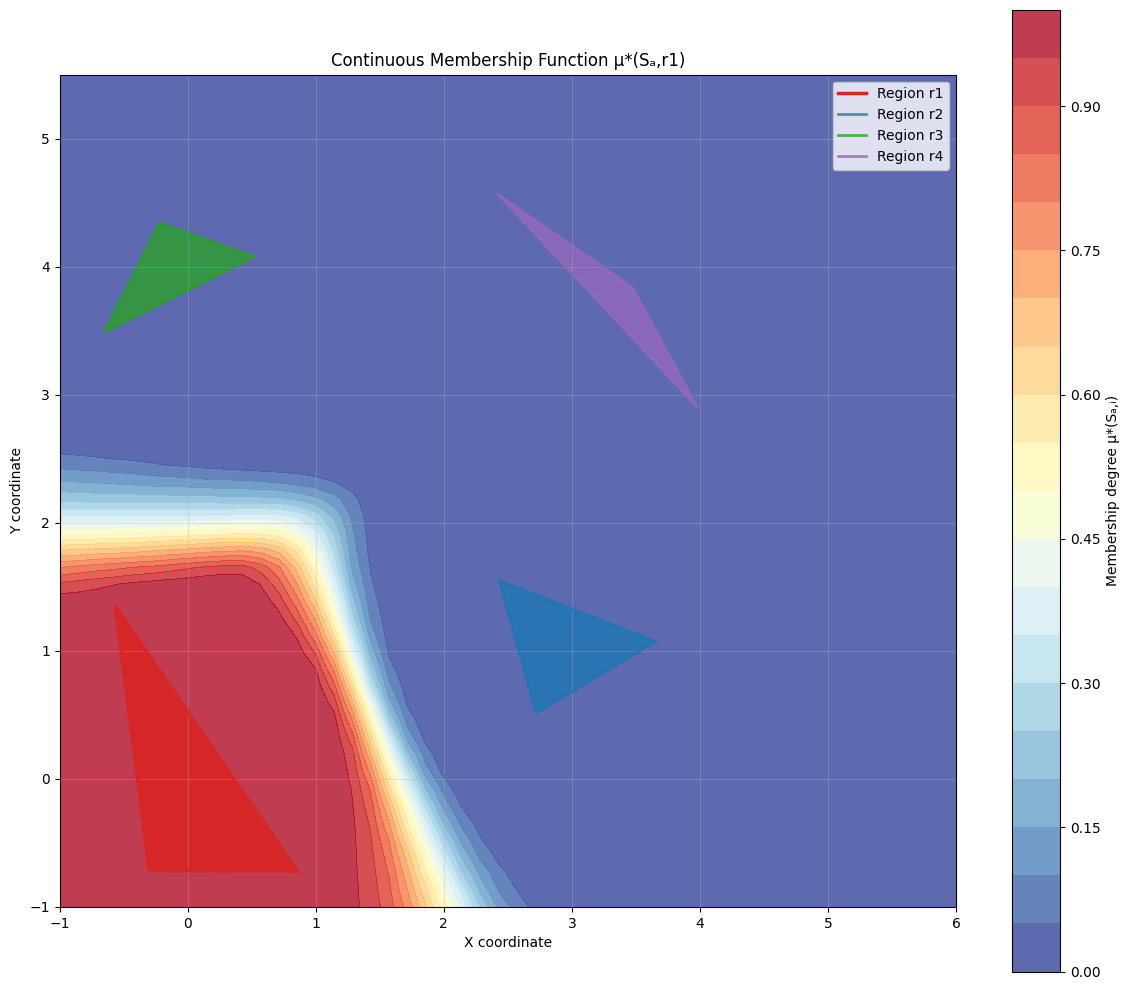


Membership Statistics for r1:
Max membership value: 1.000
Min membership value: 0.000


In [34]:
#@title Test

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union
import itertools
from matplotlib.patches import Polygon as MPLPolygon
from matplotlib.collections import LineCollection
import warnings
import cupy as cp
import random

warnings.filterwarnings('ignore')

# Step 1: Environment Setup and Data Definition

# Define the 12 vertices for the 4 triangular prototypical regions
TRIANGLE_SPREAD = 1.1

def random_triangle(center_x, center_y, spread=1):
    """Generates the 3 vertices of a random triangle around a center point."""
    return [
        (round(center_x + random.uniform(-spread, spread), 8), round(center_y + random.uniform(-spread, spread), 8)),
        (round(center_x + random.uniform(-spread, spread), 8), round(center_y + random.uniform(-spread, spread), 8)),
        (round(center_x + random.uniform(-spread, spread), 8), round(center_y + random.uniform(-spread, spread), 8)),
    ]

# Define the center points for four triangles in different quadrants
centers = [
    (random.uniform(0, 1), random.uniform(0, 1)),
    (random.uniform(3, 4), random.uniform(0, 1)),
    (random.uniform(0, 1), random.uniform(3, 4)),
    (random.uniform(3, 4), random.uniform(3, 4)),
]

# Generate the dictionary of triangles
vertices = {
    f'r{i+1}': random_triangle(cx, cy, spread=TRIANGLE_SPREAD)
    for i, (cx, cy) in enumerate(centers)
}


# Create Shapely Polygon objects for each prototypical region
prototypical_regions = {
    name: Polygon(verts) for name, verts in vertices.items()
}

# Select target region (e.g., r1)
target_region = 'r1'
target_index = 0  # Index for r1

# Step 2: Discrete Framework Analysis

def generate_discrete_configurations():
    """Generate all 81 discrete configurations from vertex combinations."""
    configurations = []
    for combo in itertools.product(*[vertices[f'r{i+1}'] for i in range(4)]):
        configurations.append(combo)
    return configurations

def compute_voronoi_edges(points, bbox_size=10):
    """Compute Voronoi diagram and return edges clipped to bbox."""
    # Add buffer points far outside to bound the diagram
    buffer_points = [
        (-bbox_size, -bbox_size), (bbox_size, -bbox_size),
        (bbox_size, bbox_size), (-bbox_size, bbox_size)
    ]
    extended_points = list(points) + buffer_points

    vor = Voronoi(extended_points)
    edges = []

    for simplex in vor.ridge_vertices:
        if -1 not in simplex:
            p1 = vor.vertices[simplex[0]]
            p2 = vor.vertices[simplex[1]]
            edges.append((p1, p2))

    return edges

# Generate all discrete configurations
discrete_configs = generate_discrete_configurations()
print(f"Generated {len(discrete_configs)} discrete configurations")

# Compute all Voronoi edges
all_voronoi_edges = []
for config in discrete_configs:
    edges = compute_voronoi_edges(config)
    all_voronoi_edges.extend(edges)

# Step 3: Calculate the Conceptual Core

def get_voronoi_cell(vor, point_idx, bbox):
    """Extract the Voronoi cell for a given point as a Polygon."""
    region_idx = vor.point_region[point_idx]
    region = vor.regions[region_idx]

    if -1 in region or len(region) == 0:
        return None

    vertices = [vor.vertices[i] for i in region]

    # Check if vertices form a valid polygon
    if len(vertices) < 3:
        return None

    try:
        cell = Polygon(vertices)
        # Clip to bounding box
        clipped = cell.intersection(bbox)
        return clipped if clipped.is_valid else None
    except:
        return None

def compute_conceptual_core(configs, target_idx, bbox_size=10):
    """Compute the intersection of all relevant Voronoi cells."""
    bbox = Polygon([
        (-bbox_size, -bbox_size), (bbox_size, -bbox_size),
        (bbox_size, bbox_size), (-bbox_size, bbox_size)
    ])

    relevant_cells = []

    for config in configs:
        # Add buffer points
        buffer_points = [
            (-bbox_size*2, -bbox_size*2), (bbox_size*2, -bbox_size*2),
            (bbox_size*2, bbox_size*2), (-bbox_size*2, bbox_size*2)
        ]
        extended_points = list(config) + buffer_points

        vor = Voronoi(extended_points)
        cell = get_voronoi_cell(vor, target_idx, bbox)

        if cell and cell.is_valid and not cell.is_empty:
            relevant_cells.append(cell)

    # Compute intersection
    if relevant_cells:
        core = relevant_cells[0]
        for cell in relevant_cells[1:]:
            core = core.intersection(cell)
            if core.is_empty:
                break
        return core if core.is_valid and not core.is_empty else None

    return None

# Calculate conceptual core
conceptual_core = compute_conceptual_core(discrete_configs, target_index)
print(f"Conceptual core computed: {conceptual_core is not None}")

# Step 4: Monte Carlo Simulation for Continuous Membership Function

vertices_gpu = {
    name: cp.array(verts, dtype=cp.float32) for name, verts in vertices.items()
}

def sample_point_in_triangle_gpu(triangle_vertices, n_samples):
    """Generates n_samples random points inside a triangle on the GPU."""
    v1, v2, v3 = triangle_vertices[0], triangle_vertices[1], triangle_vertices[2]

    # Generate random barycentric coordinates on the GPU
    r = cp.random.random((n_samples, 2), dtype=cp.float32)

    # Condition to keep points within the triangle bounds
    r1 = cp.where(r[:, 0] + r[:, 1] > 1, 1 - r[:, 0], r[:, 0])
    r2 = cp.where(r[:, 0] + r[:, 1] > 1, 1 - r[:, 1], r[:, 1])

    # Reshape for broadcasting
    r1 = r1.reshape(-1, 1)
    r2 = r2.reshape(-1, 1)
    r3 = 1 - r1 - r2

    # Convert to Cartesian coordinates using broadcasted multiplication
    points = r1 * v1 + r2 * v2 + r3 * v3
    return points

def compute_membership_monte_carlo_gpu(points_grid, n_samples=2000):
    """
    Computes μ*(Sₐ,ᵢ) for an entire grid of points at once on the GPU.
    """
    num_grid_points = points_grid.shape[0]

    # 1. Generate all random configurations at once on the GPU
    # Shape: (n_samples, 4, 2) -> 2000 samples for each of the 4 regions
    config_samples = cp.empty((n_samples, 4, 2), dtype=cp.float32)
    for i in range(4):
        triangle_verts = vertices_gpu[f'r{i+1}']
        config_samples[:, i, :] = sample_point_in_triangle_gpu(triangle_verts, n_samples)

    # 2. Prepare grid points for broadcasting
    # Reshape points_grid from (num_grid_points, 2) to (num_grid_points, 1, 1, 2)
    # Reshape config_samples from (n_samples, 4, 2) to (1, n_samples, 4, 2)
    # This allows NumPy/CuPy to broadcast and compare every grid point against every sample config
    points_grid_b = points_grid.reshape(num_grid_points, 1, 1, 2)
    config_samples_b = config_samples.reshape(1, n_samples, 4, 2)

    # 3. Compute all distances in a single, massive operation
    # The result `distances` will have shape: (num_grid_points, n_samples, 4)
    distances = cp.linalg.norm(points_grid_b - config_samples_b, axis=3)

    # 4. Find which region was closest for each sample
    # Result `closest_indices` has shape: (num_grid_points, n_samples)
    closest_indices = cp.argmin(distances, axis=2)

    # 5. For each grid point, count how many times the target_index was the closest
    # `cp.sum` over axis=1 (the samples axis)
    favorable_counts = cp.sum(closest_indices == target_index, axis=1)

    # 6. Calculate membership and return to CPU
    membership = favorable_counts / n_samples
    return membership.get() # .get() moves the array from GPU memory to CPU memory

# --- Main execution part for the GPU version ---
print("Computing membership values via GPU Monte Carlo...")
n_samples = 2000

# Flatten the grid and move it to the GPU
points_to_test = np.vstack([X.ravel(), Y.ravel()]).T
points_to_test_gpu = cp.asarray(points_to_test, dtype=cp.float32)

# Run the entire computation
membership_values_flat = compute_membership_monte_carlo_gpu(points_to_test_gpu, n_samples)

# Reshape the result back to the grid shape for plotting
membership_values = membership_values_flat.reshape(X.shape)

# Step 5: Final Visualization

fig, ax = plt.subplots(figsize=(12, 10))

# 1. Heatmap background
im = ax.contourf(X, Y, membership_values, levels=20, cmap='RdYlBu_r', alpha=0.8)
cbar = plt.colorbar(im, ax=ax, label='Membership degree μ*(Sₐ,ᵢ)')

# 2. Discrete grid overlay (Voronoi edges)
edge_collection = []
for edge in all_voronoi_edges:
    if edge[0] is not None and edge[1] is not None:
        edge_collection.append([edge[0], edge[1]])

if edge_collection:
    lc = LineCollection(edge_collection, colors='black', linewidths=0, alpha=0.5)
    ax.add_collection(lc)


# 3. Draw and fill prototypical regions (triangles)
# Define a distinct color for each of the 4 regions
region_colors = {'r1': '#d62728', 'r2': '#1f77b4', 'r3': '#2ca02c', 'r4': '#9467bd'} # Red, Blue, Green, Purple
for name, region in prototypical_regions.items():
    x, y = region.exterior.xy
    color = region_colors[name]

    is_target = (name == target_region)
    outline_alpha = 1.0 if is_target else 0.8
    linewidth = 2.5 if is_target else 2.0

    # We will now use 'outline_alpha' for both the line and the fill,
    # so the 'fill_alpha' variable is no longer needed.

    # Draw the outline, labeling each region for the legend
    ax.plot(x, y, color=color, linewidth=linewidth, alpha=outline_alpha, label=f'Region {name}')

    # Fill the region with the same color AND THE SAME ALPHA as the outline
    ax.fill(x, y, color=color, alpha=outline_alpha)


# Formatting
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 5.5)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title(f'Continuous Membership Function μ*(Sₐ,{target_region})')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Additional analysis: Show membership statistics
print(f"\nMembership Statistics for {target_region}:")
print(f"Max membership value: {np.max(membership_values):.3f}")
print(f"Min membership value: {np.min(membership_values):.3f}")

In [15]:
import random
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def generate_random_triangles(num_triangles=3, canvas_size=(100, 100), min_center_dist=30, cluster_radius=5):
    width, height = canvas_size
    centers = []

    # 1. Generate centroids that are "far apart" from each other
    while len(centers) < num_triangles:
        # Pick a random candidate for a new center
        candidate_center = (random.uniform(cluster_radius, width - cluster_radius),
                            random.uniform(cluster_radius, height - cluster_radius))

        # Check if it's far enough from all existing centers
        is_far_enough = True
        for existing_center in centers:
            dist = math.hypot(candidate_center[0] - existing_center[0],
                             candidate_center[1] - existing_center[1])
            if dist < min_center_dist:
                is_far_enough = False
                break

        if is_far_enough:
            centers.append(candidate_center)

    # 2. Generate triangle vertices in a "tight cluster" around each centroid
    triangles = {}
    for i, center in enumerate(centers):
        vertices = []
        for _ in range(3):  # A triangle has 3 vertices
            # Generate a random point within a circle of 'cluster_radius' around the center
            angle = random.uniform(0, 2 * math.pi)
            radius = random.uniform(0, cluster_radius)

            offset_x = radius * math.cos(angle)
            offset_y = radius * math.sin(angle)

            vertex_x = center[0] + offset_x
            vertex_y = center[1] + offset_y

            vertices.append((vertex_x, vertex_y))

        triangles[f't{i+1}'] = vertices

    return triangles

def visualize_triangles(triangles_dict, canvas_size=(100, 100)):
    """Plots the generated triangles using Matplotlib."""
    fig, ax = plt.subplots()

    # Use a color cycle for different triangles
    colors = plt.cm.viridis([i/len(triangles_dict) for i in range(len(triangles_dict))])

    for i, (name, vertices) in enumerate(triangles_dict.items()):
        # Draw the triangle
        poly = Polygon(vertices, closed=True, facecolor=colors[i], alpha=0.6, edgecolor='k')
        ax.add_patch(poly)

        # Plot the vertices as points
        x_coords, y_coords = zip(*vertices)
        ax.scatter(x_coords, y_coords, c='black', s=20, zorder=5)

    ax.set_xlim(0, canvas_size[0])
    ax.set_ylim(0, canvas_size[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"{len(triangles_dict)} Random Triangles")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


generated_vertices = generate_random_triangles(
    num_triangles=3,
    canvas_size=(100, 100), # Triangles will be in a 100x100 area
    min_center_dist=40,    # Their centers must be at least 40 units apart
    cluster_radius=8       # Vertices will be within 8 units of their center
)

Generated 81 discrete configurations
Conceptual core computed: True
Computing membership values via GPU Monte Carlo...


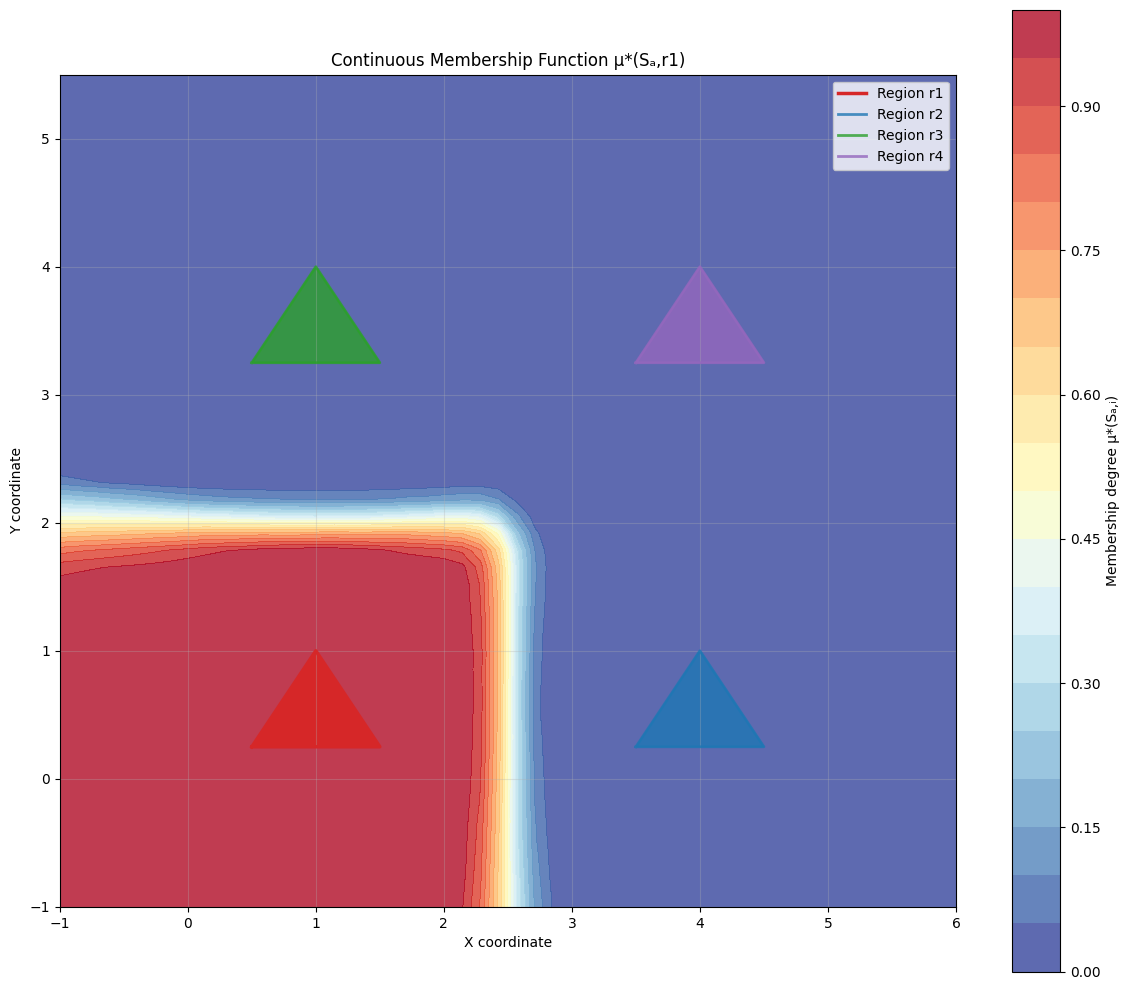


Membership Statistics for r1:
Max membership value: 1.000
Min membership value: 0.000


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union
import itertools
from matplotlib.patches import Polygon as MPLPolygon
from matplotlib.collections import LineCollection
import warnings
import cupy as cp
warnings.filterwarnings('ignore')

# Step 1: Environment Setup and Data Definition

# Define the 12 vertices for the 4 triangular prototypical regions
vertices = {
    'r1': [(0.50000000, 0.25000000), (1.50000000, 0.25000000), (1.00000000, 1.00000000)],
    'r2': [(3.50000000, 0.25000000), (4.50000000, 0.25000000), (4.00000000, 1.00000000)],
    'r3': [(0.50000000, 3.25000000), (1.50000000, 3.25000000), (1.00000000, 4.00000000)],
    'r4': [(3.50000000, 3.25000000), (4.50000000, 3.25000000), (4.00000000, 4.00000000)],
}

# Create Shapely Polygon objects for each prototypical region
prototypical_regions = {
    name: Polygon(verts) for name, verts in vertices.items()
}

# Select target region (e.g., r1)
target_region = 'r1'
target_index = 0  # Index for r1

# Step 2: Discrete Framework Analysis

def generate_discrete_configurations():
    """Generate all 81 discrete configurations from vertex combinations."""
    configurations = []
    for combo in itertools.product(*[vertices[f'r{i+1}'] for i in range(4)]):
        configurations.append(combo)
    return configurations

def compute_voronoi_edges(points, bbox_size=10):
    """Compute Voronoi diagram and return edges clipped to bbox."""
    # Add buffer points far outside to bound the diagram
    buffer_points = [
        (-bbox_size, -bbox_size), (bbox_size, -bbox_size),
        (bbox_size, bbox_size), (-bbox_size, bbox_size)
    ]
    extended_points = list(points) + buffer_points

    vor = Voronoi(extended_points)
    edges = []

    for simplex in vor.ridge_vertices:
        if -1 not in simplex:
            p1 = vor.vertices[simplex[0]]
            p2 = vor.vertices[simplex[1]]
            edges.append((p1, p2))

    return edges

# Generate all discrete configurations
discrete_configs = generate_discrete_configurations()
print(f"Generated {len(discrete_configs)} discrete configurations")

# Compute all Voronoi edges
all_voronoi_edges = []
for config in discrete_configs:
    edges = compute_voronoi_edges(config)
    all_voronoi_edges.extend(edges)

# Step 3: Calculate the Conceptual Core

def get_voronoi_cell(vor, point_idx, bbox):
    """Extract the Voronoi cell for a given point as a Polygon."""
    region_idx = vor.point_region[point_idx]
    region = vor.regions[region_idx]

    if -1 in region or len(region) == 0:
        return None

    vertices = [vor.vertices[i] for i in region]

    # Check if vertices form a valid polygon
    if len(vertices) < 3:
        return None

    try:
        cell = Polygon(vertices)
        # Clip to bounding box
        clipped = cell.intersection(bbox)
        return clipped if clipped.is_valid else None
    except:
        return None

def compute_conceptual_core(configs, target_idx, bbox_size=10):
    """Compute the intersection of all relevant Voronoi cells."""
    bbox = Polygon([
        (-bbox_size, -bbox_size), (bbox_size, -bbox_size),
        (bbox_size, bbox_size), (-bbox_size, bbox_size)
    ])

    relevant_cells = []

    for config in configs:
        # Add buffer points
        buffer_points = [
            (-bbox_size*2, -bbox_size*2), (bbox_size*2, -bbox_size*2),
            (bbox_size*2, bbox_size*2), (-bbox_size*2, bbox_size*2)
        ]
        extended_points = list(config) + buffer_points

        vor = Voronoi(extended_points)
        cell = get_voronoi_cell(vor, target_idx, bbox)

        if cell and cell.is_valid and not cell.is_empty:
            relevant_cells.append(cell)

    # Compute intersection
    if relevant_cells:
        core = relevant_cells[0]
        for cell in relevant_cells[1:]:
            core = core.intersection(cell)
            if core.is_empty:
                break
        return core if core.is_valid and not core.is_empty else None

    return None

# Calculate conceptual core
conceptual_core = compute_conceptual_core(discrete_configs, target_index)
print(f"Conceptual core computed: {conceptual_core is not None}")

# Step 4: Monte Carlo Simulation for Continuous Membership Function

vertices_gpu = {
    name: cp.array(verts, dtype=cp.float32) for name, verts in vertices.items()
}

def sample_point_in_triangle_gpu(triangle_vertices, n_samples):
    """Generates n_samples random points inside a triangle on the GPU."""
    v1, v2, v3 = triangle_vertices[0], triangle_vertices[1], triangle_vertices[2]

    # Generate random barycentric coordinates on the GPU
    r = cp.random.random((n_samples, 2), dtype=cp.float32)

    # Condition to keep points within the triangle bounds
    r1 = cp.where(r[:, 0] + r[:, 1] > 1, 1 - r[:, 0], r[:, 0])
    r2 = cp.where(r[:, 0] + r[:, 1] > 1, 1 - r[:, 1], r[:, 1])

    # Reshape for broadcasting
    r1 = r1.reshape(-1, 1)
    r2 = r2.reshape(-1, 1)
    r3 = 1 - r1 - r2

    # Convert to Cartesian coordinates using broadcasted multiplication
    points = r1 * v1 + r2 * v2 + r3 * v3
    return points

def compute_membership_monte_carlo_gpu(points_grid, n_samples=2000):
    """
    Computes μ*(Sₐ,ᵢ) for an entire grid of points at once on the GPU.
    """
    num_grid_points = points_grid.shape[0]

    # 1. Generate all random configurations at once on the GPU
    # Shape: (n_samples, 4, 2) -> 2000 samples for each of the 4 regions
    config_samples = cp.empty((n_samples, 4, 2), dtype=cp.float32)
    for i in range(4):
        triangle_verts = vertices_gpu[f'r{i+1}']
        config_samples[:, i, :] = sample_point_in_triangle_gpu(triangle_verts, n_samples)

    # 2. Prepare grid points for broadcasting
    # Reshape points_grid from (num_grid_points, 2) to (num_grid_points, 1, 1, 2)
    # Reshape config_samples from (n_samples, 4, 2) to (1, n_samples, 4, 2)
    # This allows NumPy/CuPy to broadcast and compare every grid point against every sample config
    points_grid_b = points_grid.reshape(num_grid_points, 1, 1, 2)
    config_samples_b = config_samples.reshape(1, n_samples, 4, 2)

    # 3. Compute all distances in a single, massive operation
    # The result `distances` will have shape: (num_grid_points, n_samples, 4)
    distances = cp.linalg.norm(points_grid_b - config_samples_b, axis=3)

    # 4. Find which region was closest for each sample
    # Result `closest_indices` has shape: (num_grid_points, n_samples)
    closest_indices = cp.argmin(distances, axis=2)

    # 5. For each grid point, count how many times the target_index was the closest
    # `cp.sum` over axis=1 (the samples axis)
    favorable_counts = cp.sum(closest_indices == target_index, axis=1)

    # 6. Calculate membership and return to CPU
    membership = favorable_counts / n_samples
    return membership.get() # .get() moves the array from GPU memory to CPU memory

# --- Main execution part for the GPU version ---
print("Computing membership values via GPU Monte Carlo...")
n_samples = 2000

# Flatten the grid and move it to the GPU
points_to_test = np.vstack([X.ravel(), Y.ravel()]).T
points_to_test_gpu = cp.asarray(points_to_test, dtype=cp.float32)

# Run the entire computation
membership_values_flat = compute_membership_monte_carlo_gpu(points_to_test_gpu, n_samples)

# Reshape the result back to the grid shape for plotting
membership_values = membership_values_flat.reshape(X.shape)

# Step 5: Final Visualization

fig, ax = plt.subplots(figsize=(12, 10))

# 1. Heatmap background
im = ax.contourf(X, Y, membership_values, levels=20, cmap='RdYlBu_r', alpha=0.8)
cbar = plt.colorbar(im, ax=ax, label='Membership degree μ*(Sₐ,ᵢ)')

# 2. Discrete grid overlay (Voronoi edges)
edge_collection = []
for edge in all_voronoi_edges:
    if edge[0] is not None and edge[1] is not None:
        edge_collection.append([edge[0], edge[1]])

if edge_collection:
    lc = LineCollection(edge_collection, colors='black', linewidths=0, alpha=0.5)
    ax.add_collection(lc)


# 3. Draw and fill prototypical regions (triangles)
# Define a distinct color for each of the 4 regions
region_colors = {'r1': '#d62728', 'r2': '#1f77b4', 'r3': '#2ca02c', 'r4': '#9467bd'} # Red, Blue, Green, Purple
for name, region in prototypical_regions.items():
    x, y = region.exterior.xy
    color = region_colors[name]

    is_target = (name == target_region)
    outline_alpha = 1.0 if is_target else 0.8
    linewidth = 2.5 if is_target else 2.0

    # We will now use 'outline_alpha' for both the line and the fill,
    # so the 'fill_alpha' variable is no longer needed.

    # Draw the outline, labeling each region for the legend
    ax.plot(x, y, color=color, linewidth=linewidth, alpha=outline_alpha, label=f'Region {name}')

    # Fill the region with the same color AND THE SAME ALPHA as the outline
    ax.fill(x, y, color=color, alpha=outline_alpha)


# Formatting
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 5.5)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title(f'Continuous Membership Function μ*(Sₐ,{target_region})')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Additional analysis: Show membership statistics
print(f"\nMembership Statistics for {target_region}:")
print(f"Max membership value: {np.max(membership_values):.3f}")
print(f"Min membership value: {np.min(membership_values):.3f}")

In [4]:
import numpy as np

# --- Données d'entrée ---
original_vertices = {
    'r1': [(0.29289322, 0.14644661), (1.70710678, 0.14644661), (1.0, 1.20710678)],
    'r2': [(3.29289322, 0.14644661), (4.70710678, 0.14644661), (4.0, 1.20710678)],
    'r3': [(0.29289322, 3.14644661), (1.70710678, 3.14644661), (1.0, 4.20710678)],
    'r4': [(3.29289322, 3.14644661), (4.70710678, 3.14644661), (4.0, 4.20710678)],
}

# --- Calcul ---

# Le facteur de réduction pour les longueurs afin de diviser la surface par 2.
# k^2 = 1/2  =>  k = 1/sqrt(2)
scaling_factor = 1 / np.sqrt(2)

# Dictionnaire pour stocker les nouveaux sommets
scaled_vertices = {}

print("Calcul des nouvelles coordonnées...\n")

# Itération sur chaque région prototypique
for name, verts in original_vertices.items():
    # Conversion des points en tableau NumPy pour faciliter les calculs vectoriels
    points_array = np.array(verts)

    # 1. Calculer le barycentre (moyenne des coordonnées des points)
    centroid = np.mean(points_array, axis=0)

    # Liste pour stocker les nouveaux sommets de la région en cours
    new_region_verts = []

    # 2. Appliquer la transformation à chaque sommet
    for point in points_array:
        # Vecteur allant du barycentre au point
        vector_to_point = point - centroid

        # Réduire ce vecteur par le facteur de réduction
        scaled_vector = vector_to_point * scaling_factor

        # Le nouveau point est le barycentre + le vecteur réduit
        new_point = centroid + scaled_vector

        # Ajouter le nouveau point (reconverti en tuple) à la liste
        new_region_verts.append(tuple(new_point))

    # Stocker le résultat dans le nouveau dictionnaire
    scaled_vertices[name] = new_region_verts

    print(f"Région '{name}':")
    print(f"  - Barycentre: {np.round(centroid, 3)}")
    print(f"  - Nouveaux sommets: {[(round(p[0], 3), round(p[1], 3)) for p in new_region_verts]}")
    print("-" * 30)

# --- Résultat Final ---
# Affiche le dictionnaire final que vous pouvez copier-coller dans votre script principal.
print("\nVoici le dictionnaire final 'scaled_vertices' à utiliser :\n")
print("vertices = {")
for name, verts in scaled_vertices.items():
    # Formattage propre pour le copier-coller
    formatted_verts = ", ".join([f"({v[0]:.8f}, {v[1]:.8f})" for v in verts])
    print(f"    '{name}': [{formatted_verts}],")
print("}")

Calcul des nouvelles coordonnées...

Région 'r1':
  - Barycentre: [1.  0.5]
  - Nouveaux sommets: [(np.float64(0.5), np.float64(0.25)), (np.float64(1.5), np.float64(0.25)), (np.float64(1.0), np.float64(1.0))]
------------------------------
Région 'r2':
  - Barycentre: [4.  0.5]
  - Nouveaux sommets: [(np.float64(3.5), np.float64(0.25)), (np.float64(4.5), np.float64(0.25)), (np.float64(4.0), np.float64(1.0))]
------------------------------
Région 'r3':
  - Barycentre: [1.  3.5]
  - Nouveaux sommets: [(np.float64(0.5), np.float64(3.25)), (np.float64(1.5), np.float64(3.25)), (np.float64(1.0), np.float64(4.0))]
------------------------------
Région 'r4':
  - Barycentre: [4.  3.5]
  - Nouveaux sommets: [(np.float64(3.5), np.float64(3.25)), (np.float64(4.5), np.float64(3.25)), (np.float64(4.0), np.float64(4.0))]
------------------------------

Voici le dictionnaire final 'scaled_vertices' à utiliser :

vertices = {
    'r1': [(0.50000000, 0.25000000), (1.50000000, 0.25000000), (1.00000000, 1